In [2]:
import os, json, random, shutil
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sahi.utils.coco import Coco, CocoCategory, CocoImage, CocoAnnotation
from sahi.slicing import slice_coco

# Нарежем исходные изображения большого размера на отдельные тайлы размером 640x640 с перекрытием 0.2

In [ ]:
import sahi, inspect
from sahi.slicing import slice_coco

print("SAHI version:", sahi.__version__)

SAHI version: 0.11.32
process_type in slice_coco: False


In [ ]:
IMG_DIR              = Path("02_part_dataset_human_rescue/images")
LABEL_DIR            = Path("02_part_dataset_human_rescue/labels")
OUT_DIR              = Path("02_part_dataset_human_rescue/sliced640")
SLICE_SIZE           = 640
OVERLAP_RATIO        = 0.2
NEG_RATIO            = 3
RAND_SEED            = 14

In [4]:
random.seed(RAND_SEED)
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
coco = Coco()
coco.add_category(CocoCategory(id=0, name="person"))

In [ ]:
for img_path in tqdm(sorted(IMG_DIR.glob("*.jp*g"))):
    w, h = Image.open(img_path).size
    img  = CocoImage(file_name=img_path.name, width=w, height=h)

    txt_path = LABEL_DIR / f"{img_path.stem}.txt"
    if txt_path.exists() and txt_path.stat().st_size > 0:          
        with open(txt_path) as f:
            for line in f:
                line = line.strip()
                if not line:                                       
                    continue
                cls, cx, cy, bw, bh = map(float, line.split())
                x1 = (cx - bw / 2) * w
                y1 = (cy - bh / 2) * h
                coco_bbox = [x1, y1, bw * w, bh * h]
                img.add_annotation(
                    CocoAnnotation(bbox=coco_bbox, category_id=int(cls))
                )

    coco.add_image(img)

100%|██████████| 28020/28020 [05:17<00:00, 88.14it/s] 


In [7]:
coco_json_path = OUT_DIR / "full_coco.json"
with open(coco_json_path, "w") as f:
    json.dump(coco.json, f)

print(f"[1/3] COCO-json сохранён: {coco_json_path}")

[1/3] COCO-json сохранён: 02_part_dataset_human_rescue\sliced640\full_coco.json


In [ ]:
slice_out = OUT_DIR / "slices"
slice_out.mkdir(exist_ok=True)

sliced_coco, sliced_json_path = slice_coco(
    coco_annotation_file_path=str(coco_json_path),
    image_dir=str(IMG_DIR),
    output_dir=str(slice_out),
    output_coco_annotation_file_name="sliced_coco.json",
    slice_height=SLICE_SIZE,
    slice_width=SLICE_SIZE,
    overlap_height_ratio=OVERLAP_RATIO,
    overlap_width_ratio=OVERLAP_RATIO,
    ignore_negative_samples=False,
    # process_type="multiprocessing",
    # num_processes=8 
)
print(f"[2/3] Нарезка готова: {sliced_json_path}")


100%|██████████| 28020/28020 [2:58:29<00:00,  2.62it/s]  


[2/3] Нарезка готова: 02_part_dataset_human_rescue\sliced640\slices\sliced_coco.json_coco.json


In [9]:
pos_ids, neg_ids = [], []
for im in tqdm(sliced_coco["images"]):
    anns = [a for a in sliced_coco["annotations"] if a["image_id"] == im["id"]]
    (pos_ids if anns else neg_ids).append(im["id"])

keep_neg = set(random.sample(neg_ids,
              k=min(len(neg_ids), NEG_RATIO * len(pos_ids))))
keep_ids = set(pos_ids) | keep_neg

100%|██████████| 558963/558963 [1:00:02<00:00, 155.15it/s]


In [ ]:
usage = {}
for im in sliced_coco["images"]:
    usage[im["file_name"]] = int(im["id"] in keep_ids)

sliced_coco["images"] = [im for im in sliced_coco["images"] if im["id"] in keep_ids]
sliced_coco["annotations"] = [
    a for a in sliced_coco["annotations"] if a["image_id"] in keep_ids
]


Path(sliced_json_path).write_text(json.dumps(sliced_coco))
usage_path = OUT_DIR / "slice_usage.json"
usage_path.write_text(json.dumps(usage, indent=2))

print(f"[3/4] Отфильтровано: {len(pos_ids)} позитивов, "
      f"{len(keep_neg)} негативов (1:{NEG_RATIO})")
print(f"[4/4] Итоговый отчёт: {usage_path}")

[3/4] Отфильтровано: 35758 позитивов, 71516 негативов (1:2)
[4/4] Итоговый отчёт: 02_part_dataset_human_rescue\sliced640\slice_usage.json


In [6]:
# — если нужно действительно удалить «лишние» jpg, раскомментируйте
# for im_id in neg_ids:
#     if im_id not in keep_neg:
#         name = next(im["file_name"] for im in sliced_coco["images"] if im["id"] == im_id)
#         ('02_part_dataset_human_rescue/sliced640/slices' / name).unlink(missing_ok=True)

In [20]:
file_names = set([item['file_name'] for item in sliced_coco["images"]])
len(file_names)

107274

In [ ]:
# file_names = set([item.removesuffix('.txt') + '.png' for item in os.listdir('02_part_dataset_human_rescue/part1/sliced640/labels')])
# len(file_names)

15388

In [24]:
counter = 0
for item in os.listdir('02_part_dataset_human_rescue/sliced640/slices'):
    if item in file_names:
        continue
    elif item not in file_names:
        pass
        Path.unlink(f'02_part_dataset_human_rescue/sliced640/slices/{item}')
    counter += 1
print(counter)

451689


In [ ]:
for item in os.listdir('02_part_dataset_human_rescue//sliced640/labels'):
    base = item.removesuffix('.txt') + '.png'
    file = Path(f'02_part_dataset_human_rescue/part1/sliced640/images/{base}')
    ex = file.exists()
    if not ex:
        Path.touch(f'02_part_dataset_human_rescue/part1/sliced640/labels/{base}')

In [ ]:
import json, os, pathlib

USAGE_JSON   = "02_part_dataset_human_rescue/part2/sliced640/slice_usage.json"
SLICE_DIR    = pathlib.Path("02_part_dataset_human_rescue/part2/sliced640/slices")
DRY_RUN      = False

with open(USAGE_JSON, "r") as f:
    usage = json.load(f)

removed, kept, missing = 0, 0, 0

for fname, flag in tqdm(usage.items()):
    if flag:
        kept += 1
        continue

    fpath = SLICE_DIR / fname
    if fpath.exists():
        if DRY_RUN:
            #print("[dry] would delete", fpath)
            pass
        else:
            fpath.unlink()
        removed += 1
    else:
        missing += 1

print(f"Done. Removed: {removed}: {kept}, missing on disk: {missing}")


100%|██████████| 24625/24625 [00:00<00:00, 3525557.62it/s]

Done. Removed: 0, kept (flag=1): 24625, missing on disk: 0


In [ ]:
import json
from pathlib import Path

COCO_JSON = Path("02_part_dataset_human_rescue/sliced640/sliced_coco.json_coco.json")

with COCO_JSON.open() as f:
    coco = json.load(f)

n_images = len(coco.get("images", []))
print(f"Всего уникальных изображений: {n_images}")

unique_files = {img["file_name"] for img in coco.get("images", [])}
print(f"Уникальных file_name:        {len(unique_files)}")

Всего уникальных изображений: 107274
Уникальных file_name:        107274


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def draw_bbox(img_path, bbox, fmt="coco", color=(255, 0, 0), thickness=2):
    """
    Draw a bounding box on an *in‑memory copy* of the image and display.
    
    Parameters
    ----------
    img_path : str or Path
        Path to the source image (PNG/JPG). The file **is not modified.**
    bbox : list/tuple
        • For ``fmt='coco'`` – [x, y, w, h] (absolute pixels, top‑left origin).  
        • For ``fmt='yolo'`` – [cx, cy, w, h] (relative 0‑1 floats).  
    fmt : {'coco', 'yolo'}, default 'coco'
        Format of the bbox.
    color : tuple(int, int, int)
        Rectangle BGR color (default red).
    thickness : int
        Line thickness.
    """
    img_path = Path(img_path)
    if not img_path.exists():
        raise FileNotFoundError(img_path)
        
    img = cv2.imread(str(img_path))  # BGR
    h, w = img.shape[:2]
    
    if fmt == "coco":
        x, y, bw, bh = bbox
        x1, y1 = int(x), int(y)
        x2, y2 = int(x + bw), int(y + bh)
    elif fmt == "yolo":
        l, cx, cy, bw, bh = bbox
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)
    else:
        raise ValueError("fmt must be 'coco' or 'yolo'")
    
    img_draw = img.copy()
    cv2.rectangle(img_draw, (x1, y1), (x2, y2), color, thickness)
    img_rgb = cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"{img_path.name}  |  bbox: {bbox} ({fmt})")
    plt.show()

## Проверка отрисовки на обрезанных

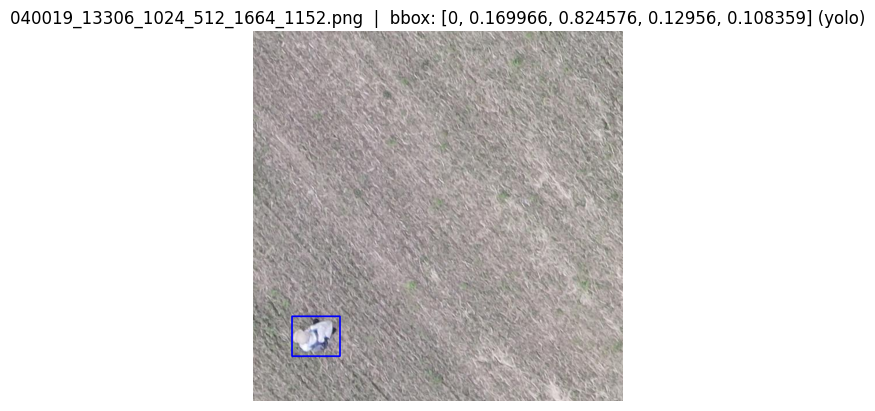

In [ ]:
draw_bbox(
    img_path="02_part_dataset_human_rescue/part2/sliced640/slices/018630_0_1536_512_2176_1152.png",
    bbox=[0, 0.169966, 0.824576, 0.129560, 0.108359],
    fmt="yolo"
)

## COCO->YOLO

In [ ]:
import json, os, pathlib
from collections import defaultdict

COCO_JSON      = "02_part_dataset_human_rescue/sliced640/sliced_coco.json_coco.json"
LABEL_DIR      = Path("02_part_dataset_human_rescue/sliced640/labels/")
WRITE_EMPTY    = True  # создавать ли пустые txt

LABEL_DIR.mkdir(exist_ok=True)

with open(COCO_JSON) as f:
    coco = json.load(f)

img_info = {im["id"]: (im["file_name"], im["width"], im["height"])
            for im in coco["images"]}

cat2yolo = {c["id"]: i for i, c in enumerate(coco["categories"])}
print("Категории:", {cat2yolo[k]: v["name"] for k, v in {c["id"]: c for c in coco["categories"]}.items()})

ann_by_image = defaultdict(list)
for ann in tqdm(coco["annotations"]):
    if ann.get("iscrowd", 0):
        continue
    img_id = ann["image_id"]
    ann_by_image[img_id].append(ann)

for img_id, (fname, w, h) in tqdm(img_info.items()):
    stem = pathlib.Path(fname).stem
    txt_path = LABEL_DIR / f"{stem}.txt"

    anns = ann_by_image.get(img_id, [])
    if not anns and not WRITE_EMPTY:
        continue

    with open(txt_path, "w") as f:
        for ann in anns:
            cls  = cat2yolo[ann["category_id"]]
            x, y, bw, bh = ann["bbox"]
            cx, cy = x + bw / 2, y + bh / 2
            line = f"{cls} {cx / w:.6f} {cy / h:.6f} {bw / w:.6f} {bh / h:.6f}\n"
            f.write(line)

print("YOLO-разметка в папке:", LABEL_DIR)


Категории: {0: 'person'}


100%|██████████| 107274/107274 [00:23<00:00, 4498.00it/s]

Готово! YOLO-разметка в папке: 02_part_dataset_human_rescue\sliced640\labels


In [ ]:
import numpy as np
from ultralytics import YOLO
import torch
from typing import List, Union

model = YOLO("epoch1.pt")
CONF_THRESHOLD = 0.1

import torch
from torchvision.ops import nms

def infer_image_bbox(image: np.ndarray) -> List[dict]:
    """Инференс YOLOv8 на изображении любого размера с нарезкой на тайлы 640x640 и NMS."""
    res_list = []

    h_img, w_img = image.shape[:2]
    tile_size = 640
    stride = tile_size

    # Разрезка на тайлы
    tiles = []
    tile_coords = []  # (x_offset, y_offset)
    for y in range(0, h_img, stride):
        for x in range(0, w_img, stride):
            tile = image[y:min(y + tile_size, h_img),
                         x:min(x + tile_size, w_img)]
            tiles.append(tile)
            tile_coords.append((x, y))

    # Прогон всех тайлов через YOLO
    results = model.predict(
        source=tiles,
        imgsz=tile_size,
        conf=CONF_THRESHOLD,
        device=0 if torch.cuda.is_available() else "cpu",
        verbose=False
    )

    raw_boxes = []  # сюда сложим все боксы для NMS
    raw_scores = []

    for (res, (x_off, y_off)) in zip(results, tile_coords):
        for box in res.boxes:
            label = int(box.cls[0])
            if label != 0:
                continue

            x1, y1, x2, y2 = box.xyxy[0].tolist()
            conf = float(box.conf[0])

            # смещение к глобальным координатам
            x1_global = x1 + x_off
            x2_global = x2 + x_off
            y1_global = y1 + y_off
            y2_global = y2 + y_off

            raw_boxes.append([x1_global, y1_global, x2_global, y2_global])
            raw_scores.append(conf)

    if raw_boxes:
        # переводим в тензоры для NMS
        boxes_tensor = torch.tensor(raw_boxes, dtype=torch.float32)
        scores_tensor = torch.tensor(raw_scores, dtype=torch.float32)

        # применяем NMS
        keep_indices = nms(boxes_tensor, scores_tensor, iou_threshold=0.1)

        for idx in keep_indices:
            x1_global, y1_global, x2_global, y2_global = boxes_tensor[idx].tolist()
            conf = scores_tensor[idx].item()

            xc = ((x1_global + x2_global) / 2) / w_img
            yc = ((y1_global + y2_global) / 2) / h_img
            w = (x2_global - x1_global) / w_img
            h = (y2_global - y1_global) / h_img

            res_list.append({
                'label': 0,
                'xc': xc,
                'yc': yc,
                'w': w,
                'h': h,
                'score': conf,
                'w_img': w_img,
                'h_img': h_img
            })

    if not res_list:
        res_list.append({
            'label': 0,
            'xc': None,
            'yc': None,
            'w': None,
            'h': None,
            'score': None,
            'w_img': w_img,
            'h_img': h_img
        })

    return res_list


def predict(images: Union[List[np.ndarray], np.ndarray]) -> List[List[dict]]:
    """Функция производит инференс модели на одном или нескольких изображениях.

    Args:
        images (Union[List[np.ndarray], np.ndarray]): Список изображений или одно изображение.

    Returns:
        List[List[dict]]: Список списков словарей с результатами предикта 
        на найденных изображениях.
        Пример выходных данных:
        [
            [
                {
                    'xc': 0.5,
                    'yc': 0.5,
                    'w': 0.2,
                    'h': 0.3,
                    'label': 0,
                    'score': 0.95
                },
                ...
            ],
            ...
        ]
    """    
    results = []
    if isinstance(images, np.ndarray):
        images = [images]

    for image in images:        
        image_results = infer_image_bbox(image)
        results.append(image_results)
    
    return results

In [59]:
import cv2
from matplotlib import pyplot as plt
images_for_test = [cv2.cvtColor(cv2.imread('D:/02_part_dataset_human_rescue/images/01_1_000001.JPG'), cv2.COLOR_BGR2RGB),
                   cv2.cvtColor(cv2.imread('D:/02_part_dataset_human_rescue/images/01_1_000002.JPG'), cv2.COLOR_BGR2RGB)]

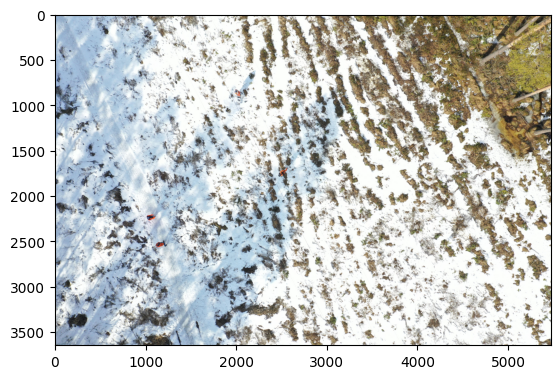

In [60]:
images_for_test
plt.imshow(images_for_test[0])

In [95]:
result = predict(images_for_test)

In [ ]:
import cv2
import matplotlib.pyplot as plt

def visualize_bboxes(image_path: str, bboxes: list):
    """
    Визуализирует нормированные bbox'ы на изображении.

    Args:
        image_path (str): путь до изображения
        bboxes (list): список словарей с ключами 'xc', 'yc', 'w', 'h', 'score', 'w_img', 'h_img'
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for bbox in bboxes:
        if bbox["xc"] is None:
            continue

        w_img = bbox["w_img"]
        h_img = bbox["h_img"]

        xc_px = bbox["xc"] * w_img
        yc_px = bbox["yc"] * h_img
        w_px = bbox["w"] * w_img
        h_px = bbox["h"] * h_img

        x1 = int(xc_px - w_px / 2)
        y1 = int(yc_px - h_px / 2)
        x2 = int(xc_px + w_px / 2)
        y2 = int(yc_px + h_px / 2)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

        label_text = f"{bbox['label']} ({bbox['score']:.2f})"
        cv2.putText(img, label_text, (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.show()


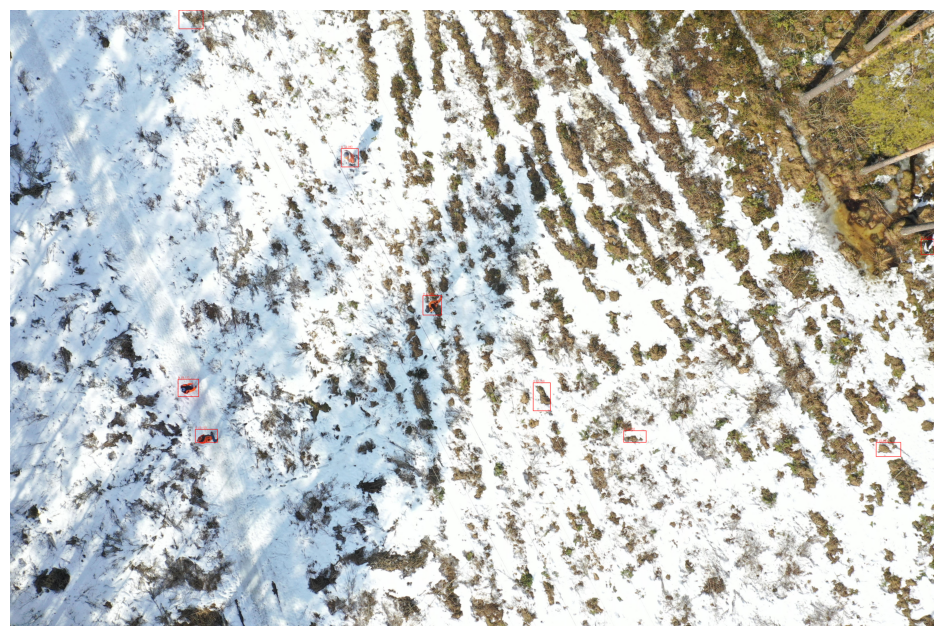

In [96]:
visualize_bboxes(image_path="D:/02_part_dataset_human_rescue/images/01_1_000001.JPG", bboxes=result[0])